# Install Dependencies and Download Dataset

In [2]:
from google.colab import files
files.upload()

# Move kaggle.json to proper location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install Kaggle CLI
!pip install -q kaggle

# Download CelebA from Kaggle
!kaggle datasets download -d jessicali9530/celeba-dataset

!mkdir -p data/celeba
# Unzip it
!unzip -q celeba-dataset.zip -d data/celeba


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 99% 1.32G/1.33G [00:09<00:00, 252MB/s]
100% 1.33G/1.33G [00:09<00:00, 156MB/s]


# Import Libraries


In [3]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import os
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from tqdm import tqdm
import gc
import torch.nn as nn
from torchvision import models
import cv2
from sklearn.cluster import KMeans
import time


# Load and Prepare Data


In [4]:
# Load attribute CSV
attr_df = pd.read_csv("data/celeba/list_attr_celeba.csv")
# Clean and convert labels: -1 → 0
attr_df.replace(-1, 0, inplace=True)
# Use only relevant columns
df_gender = attr_df[['image_id', 'Male','Eyeglasses']]  # 1 = male, 0 = female
print(df_gender['Male'].value_counts())
print(df_gender['Eyeglasses'].value_counts())


Male
0    118165
1     84434
Name: count, dtype: int64


,count
Eyeglasses,
0,189406
1,13193


# Display Sample Images


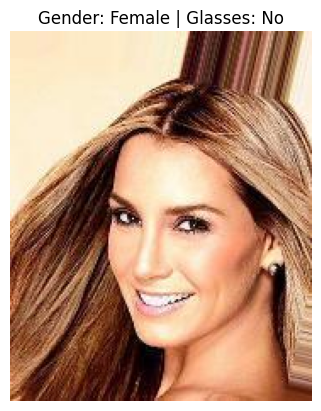

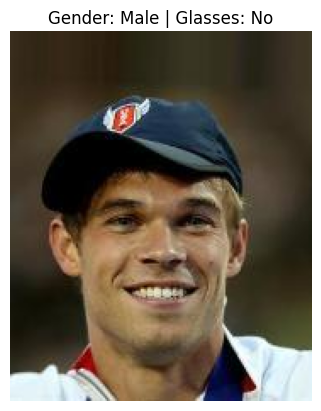

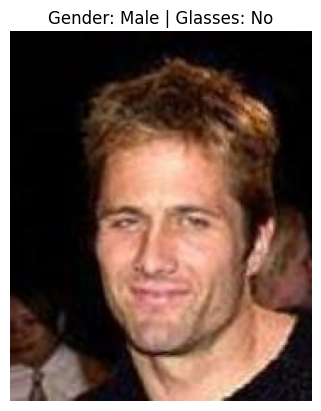

In [3]:
def show_sample(row_idx):
    row = df_gender.iloc[row_idx]
    img_path = f"data/celeba/img_align_celeba/img_align_celeba/{row['image_id']}"
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Gender: {'Male' if row['Male'] else 'Female'} | Glasses: {'Yes' if row['Eyeglasses'] else 'No'}")
    plt.axis("off")
    plt.show()

# Show random samples
show_sample(0)
show_sample(500)
show_sample(3000)


# Split Data into Training, Validation, and Test Sets

In [4]:
train_df, temp_df = train_test_split(df_gender, test_size=0.2, random_state=42, stratify=df_gender['Male'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Male'])

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 162079, Val: 20260, Test: 20260


# Create Custom Dataset and DataLoader

In [5]:
class CelebAMultiTaskDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_id'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Multi-task labels
        gender = torch.tensor(row['Male'], dtype=torch.long)
        glasses = torch.tensor(row['Eyeglasses'], dtype=torch.long)

        return image, gender, glasses


transform = transforms.Compose([
    transforms.Resize((224, 224)), #224×224 fits ResNet input
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3) #Normalizing with [0.5, 0.5, 0.5] is simple and centered for ReLU
])

img_dir = "data/celeba/img_align_celeba/img_align_celeba"

train_set = CelebAMultiTaskDataset(train_df, img_dir, transform)
val_set = CelebAMultiTaskDataset(val_df, img_dir, transform)
test_set = CelebAMultiTaskDataset(test_df, img_dir, transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)


# Define Multi-Task ResNet Model

In [ ]:
class MultiTaskResNet(nn.Module):
    def __init__(self):
        super(MultiTaskResNet, self).__init__()
        base_model = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])  # remove fc layer

        in_features = base_model.fc.in_features
        self.fc_gender = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)  # Male/Female
        )

        self.fc_glasses = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)  # Glasses/No Glasses
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)

        gender_out = self.fc_gender(x)
        glasses_out = self.fc_glasses(x)
        return gender_out, glasses_out

# Define Training Function & Train the Model

In [7]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_gender_correct = 0
    total_glasses_correct = 0

    for imgs, genders, glasses in tqdm(dataloader):
        imgs = imgs.to(device)
        genders = genders.to(device)
        glasses = glasses.to(device)

        optimizer.zero_grad()
        gender_out, glasses_out = model(imgs)

        loss_gender = criterion(gender_out, genders)
        loss_glasses = criterion(glasses_out, glasses)
        loss = loss_gender + loss_glasses
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        gender_preds = torch.argmax(gender_out, dim=1)
        glasses_preds = torch.argmax(glasses_out, dim=1)
        total_gender_correct += (gender_preds == genders).sum().item()
        total_glasses_correct += (glasses_preds == glasses).sum().item()

    total = len(dataloader.dataset)
    return total_loss / len(dataloader), total_gender_correct / total, total_glasses_correct / total

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskResNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):  # You can increase
    loss, gender_acc, glasses_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Gender Acc={gender_acc:.4f}, Glasses Acc={glasses_acc:.4f}")
    torch.cuda.empty_cache()
    gc.collect()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]
100%|██████████| 5065/5065 [14:10<00:00,  5.95it/s]


Epoch 1: Loss=0.0812, Gender Acc=0.9779, Glasses Acc=0.9947


100%|██████████| 5065/5065 [14:17<00:00,  5.91it/s]


Epoch 2: Loss=0.0467, Gender Acc=0.9882, Glasses Acc=0.9967


100%|██████████| 5065/5065 [14:11<00:00,  5.95it/s]


Epoch 3: Loss=0.0334, Gender Acc=0.9916, Glasses Acc=0.9973


100%|██████████| 5065/5065 [14:18<00:00,  5.90it/s]


Epoch 4: Loss=0.0223, Gender Acc=0.9944, Glasses Acc=0.9982


  0%|          | 11/5065 [00:02<17:48,  4.73it/s]


KeyboardInterrupt: 

# Define Evaluation Function & Evaluate Model on Validation Set

In [8]:
def evaluate_model(model, dataloader, device):
    model.eval()
    gender_preds_all, gender_labels_all = [], []
    glasses_preds_all, glasses_labels_all = [], []

    with torch.no_grad():
        for imgs, genders, glasses in dataloader:
            imgs = imgs.to(device)
            genders = genders.to(device)
            glasses = glasses.to(device)

            gender_out, glasses_out = model(imgs)
            gender_preds = torch.argmax(gender_out, dim=1)
            glasses_preds = torch.argmax(glasses_out, dim=1)

            gender_preds_all.extend(gender_preds.cpu().numpy())
            gender_labels_all.extend(genders.cpu().numpy())
            glasses_preds_all.extend(glasses_preds.cpu().numpy())
            glasses_labels_all.extend(glasses.cpu().numpy())

    # Accuracy
    gender_acc = accuracy_score(gender_labels_all, gender_preds_all)
    glasses_acc = accuracy_score(glasses_labels_all, glasses_preds_all)

    # Confusion matrices
    gender_cm = confusion_matrix(gender_labels_all, gender_preds_all)
    glasses_cm = confusion_matrix(glasses_labels_all, glasses_preds_all)

    return gender_acc, glasses_acc, gender_cm, glasses_cm

gender_acc, glasses_acc, gender_cm, glasses_cm = evaluate_model(model, val_loader, device)

print("✅ Gender Accuracy:", round(gender_acc * 100, 2), "%")
print("✅ Glasses Accuracy:", round(glasses_acc * 100, 2), "%")

print("🧾 Gender Confusion Matrix:\n", gender_cm)
print("🧾 Glasses Confusion Matrix:\n", glasses_cm)


✅ Gender Accuracy: 98.62 %
✅ Glasses Accuracy: 99.67 %
🧾 Gender Confusion Matrix:
 [[11679   137]
 [  142  8302]]
🧾 Glasses Confusion Matrix:
 [[18909    23]
 [   44  1284]]


# Save the Model


In [9]:
torch.save(model.state_dict(), "multitask_model.pth")
print("✅ Model saved to multitask_model.pth")


✅ Model saved to multitask_model.pth


# Visualize Predictions on Validation Dataset


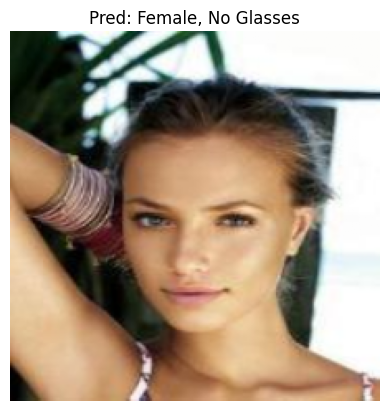

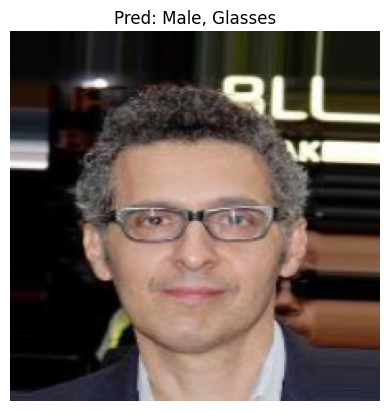

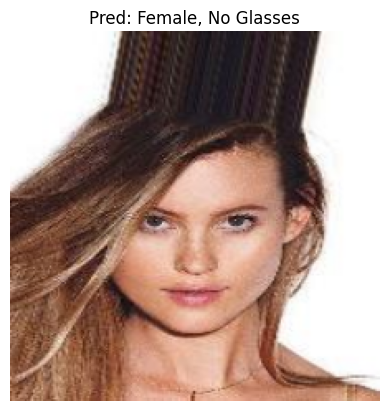

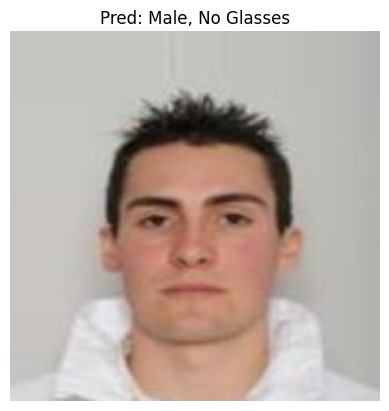

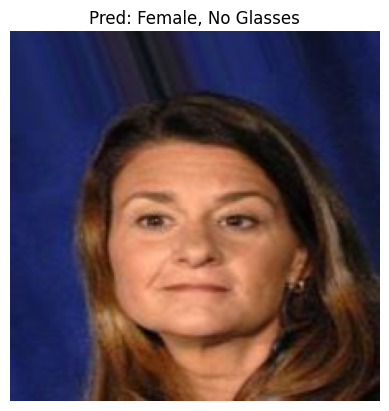

In [10]:
def visualize_predictions(model, dataset, device, num_samples=5):
    model.eval()
    for i in range(num_samples):
        image, gender_label, glasses_label = dataset[i]
        img_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            gender_out, glasses_out = model(img_tensor)
            gender_pred = torch.argmax(gender_out, dim=1).item()
            glasses_pred = torch.argmax(glasses_out, dim=1).item()

        plt.imshow(image.permute(1, 2, 0).numpy() * 0.5 + 0.5)
        plt.axis('off')
        plt.title(f"Pred: {'Male' if gender_pred else 'Female'}, {'Glasses' if glasses_pred else 'No Glasses'}")
        plt.show()

visualize_predictions(model, val_set, device, num_samples=5)



# Evaluate Model on Test Set

In [12]:
test_loader = DataLoader(test_set, batch_size=32)

gender_acc, glasses_acc, gender_cm, glasses_cm = evaluate_model(model, test_loader, device)

print(f"🎯 Gender Accuracy on Test Set: {gender_acc * 100:.2f}%")
print(f"🕶️ Glasses Accuracy on Test Set: {glasses_acc * 100:.2f}%")

print("\n🧾 Gender Confusion Matrix:\n", gender_cm)
print("\n🧾 Glasses Confusion Matrix:\n", glasses_cm)

visualize_predictions(model, test_set, device, num_samples=5)


🎯 Gender Accuracy on Test Set: 98.58%
🕶️ Glasses Accuracy on Test Set: 99.65%

🧾 Gender Confusion Matrix:
 [[11697   120]
 [  168  8275]]

🧾 Glasses Confusion Matrix:
 [[18943    28]
 [   42  1247]]


# Define Shirt Color Analysis Functions

In [18]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Define LAB color centroids (you can add more)
LAB_COLORS = {
    "Red":      [136, 208, 195],
    "Orange":   [180, 170, 200],
    "Yellow":   [240, 140, 180],
    "Green":    [224, 42, 211],
    "Blue":     [82, 207, 20],
    "Purple":   [150, 170, 90],
    "Black":    [0, 128, 128],
    "White":    [255, 128, 128],
    "Gray":     [128, 128, 128],
}

def crop_shirt_region(image):
    h, w = image.shape[:2]
    return image[int(h * 0.55):int(h * 0.85), int(w * 0.25):int(w * 0.75)]

def is_valid_crop(img):
    """Check if shirt region is valid (not empty, not background only)."""
    if img is None or img.size == 0:
        return False
    mean = img.mean()
    std = img.std()
    return mean > 25 and std > 10  # thresholds can be adjusted

def get_shirt_color(shirt_crop, k=3):
    """Extract dominant color using KMeans and match with LAB predefined colors."""
    if not is_valid_crop(shirt_crop):
        return "No Shirt Detected"

    # Resize for efficiency
    small_crop = cv2.resize(shirt_crop, (100, 100))
    pixels = small_crop.reshape(-1, 3)

    # Run KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pixels)
    cluster_centers = np.uint8(kmeans.cluster_centers_)
    labels = kmeans.labels_

    # Find most common cluster
    label_counts = np.bincount(labels)
    top_idx = label_counts.argmax()
    top_color_bgr = cluster_centers[top_idx]

    # Convert BGR to LAB
    top_color_lab = cv2.cvtColor(np.uint8([[top_color_bgr]]), cv2.COLOR_BGR2LAB)[0][0]

    # Match closest LAB color
    color_names = list(LAB_COLORS.keys())
    color_vals = np.array([LAB_COLORS[name] for name in color_names])
    closest_idx = cdist([top_color_lab], color_vals).argmin()
    matched_color = color_names[closest_idx]

    # Optional: confidence check
    top_ratio = label_counts[top_idx] / len(labels)
    if top_ratio < 0.35:  # if not dominant enough
        return "Uncertain Color"

    return matched_color


# Load Model, Upload Image, and Predict Attributes

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saving image.jpg to image (1).jpg
Gender & Glasses Prediction Inference time: 75.30 ms
Shirt-Color Prediction Inference time: 6.76 ms


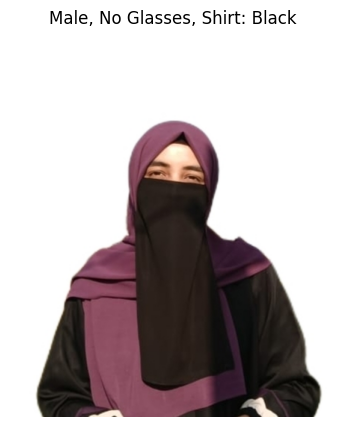


✅ Gender: Male
✅ Glasses: No Glasses
👕 Shirt Color: Black


In [19]:
model = MultiTaskResNet()
model.load_state_dict(torch.load("multitask_model.pth", map_location=torch.device("cpu")))
model.eval()

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

start = time.time()
# inference code here
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load and transform image
img = Image.open(img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0)  # shape: [1, 3, 224, 224]

# Predict
with torch.no_grad():
    gender_out, glasses_out = model(input_tensor)
print(f"Gender & Glasses Prediction Inference time: {(time.time() - start)*1000:.2f} ms")

gender_pred = torch.argmax(gender_out, dim=1).item()
glasses_pred = torch.argmax(glasses_out, dim=1).item()

gender_label = "Male" if gender_pred else "Female"
glasses_label = "With Glasses" if glasses_pred else "No Glasses"

start1 = time.time()
cv_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
shirt_crop = crop_shirt_region(cv_img)
shirt_label = get_shirt_color(shirt_crop)  # <-- Replaces get_dominant_color + map_color
print(f"Shirt-Color Prediction Inference time: {(time.time() - start1)*1000:.2f} ms")

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis("off")
plt.title(f"{gender_label}, {glasses_label}, Shirt: {shirt_label}")
plt.show()

print("✅ Gender:", gender_label)
print("✅ Glasses:", glasses_label)
print("👕 Shirt Color:", shirt_label)
